### Parte 2 - Classificação Binária

#### (a)

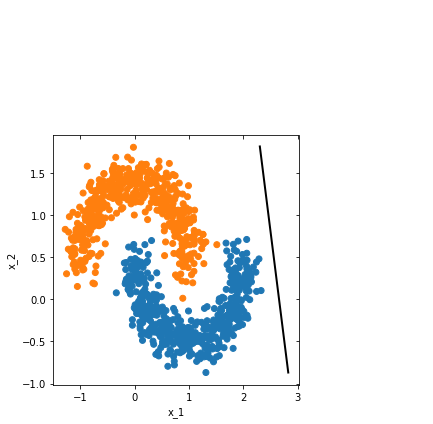

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import color_palette, JointGrid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

data = pd.read_csv('two_moons.csv',index_col=0)

X = data[['x_1','x_2']].values
y = data.y.values

y_unique = data.y.unique()

#Escolhe cores 
replace_map_comp = {k: v for k,v in zip(y_unique,color_palette(n_colors=len(y_unique)))}
colors = [replace_map_comp[a] for a in data.y.values]

   
# Utiliza a seguinte função para achar a direção de Fisher
lda = LinearDiscriminantAnalysis(n_components=1).fit(X,y)

# Seleciona a direção de Fisher
coef = lda.scalings_

# Constrói uma reta com a direção de Fishr
x_0 = [max(data.x_1)+0.5, max(data.x_1)+0.5-coef[0]]
y_0 = [min(data.x_2), min(data.x_2)-coef[1]]


grid = JointGrid(data.x_1, data.x_2, space=0, height=6, ratio=2)
f = grid.plot_joint(plt.scatter, color=colors)
f = plt.plot(x_0, y_0, linewidth=2, color='black')

Este é um problema de classificação binária não separável por um classificador linear, porém podemos observar que esses dados são distribuições distintas que não se interceptam, logo são separáveis por algum separador não linear
* 

#### (b)

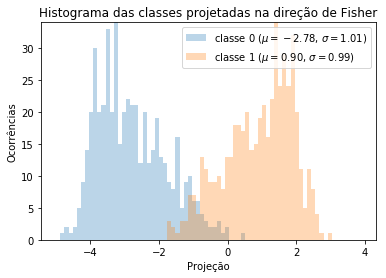

In [11]:
from math import floor, ceil 

# Calcula a projeção dos nados na direção de Fisher
X_proj = X.dot(lda.scalings_)

# Escolhe a cor de cada histograma
colors = color_palette(n_colors=len(y_unique))
bins = np.arange(floor(min(X_proj[:])), ceil(max(X_proj[:])), 0.12)

# max count for a particular bin for all classes combined
max_bin = max(np.histogram(X_proj[:], bins=bins)[0])

for label,color in zip([0, 1], colors):
    mean = np.mean(X_proj[:][y == label]) # class sample mean
    stdev = np.std(X_proj[:][y == label]) # class standard deviation
    plt.hist(X_proj[:][y == label], bins=bins, alpha=0.3, # opacity level
        label='classe {} ($\mu={:.2f}$, $\sigma={:.2f}$)'.format(label, mean, stdev),
        color=color)
plt.ylim([0, max_bin])
plt.legend(loc='upper right')
plt.title('Histograma das classes projetadas na direção de Fisher')
plt.ylabel('Ocorrências')
plt.xlabel('Projeção')
plt.show()

Como podemos observar no espaço original dos dados o problema não é separável por um classificador linear, logo vemos que existe uma intersecção dos dados ao projetá-lo na direção de Fisher.


#### (c) ROC



Melhor F1 medida: 0.954 e é obtido escolhendo threshold de -0.864


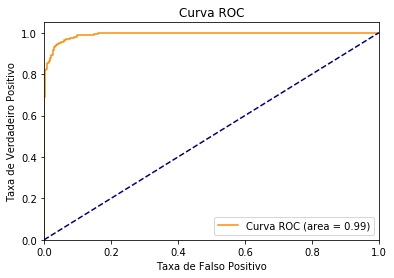

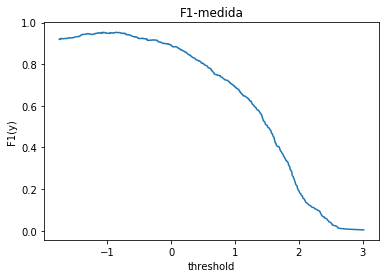

In [34]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Funcao que calcula a Fm medida, dados recall e precisao
fm = lambda m, precision, recall: ((m+1)*recall*precision)/(recall+m*precision)

fpr, tpr, _ = roc_curve(y, X_proj)
roc_auc = auc(fpr, tpr)

prec, rec, thresholds = precision_recall_curve(y, X_proj)

#Calcula a f1 medida
F1 = fm(1,prec,rec)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")

plt.figure()
plt.ylabel('F1(y)')
plt.xlabel('threshold')
plt.title('F1-medida')
f = plt.plot(thresholds, F1[:-1])

print("Melhor F1 medida: %.3f e é obtido escolhendo threshold de %.3f" % (max(F1),thresholds[np.argmax(F1)]))

Observando a F1-medida podemos observar que a qualidade deste classificador é altamente dependente do threshold escolhido.

#### (d)

Melhor F1 medida: 0.959 e é obtido escolhendo threshold de 0.393


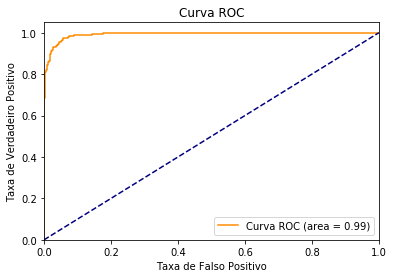

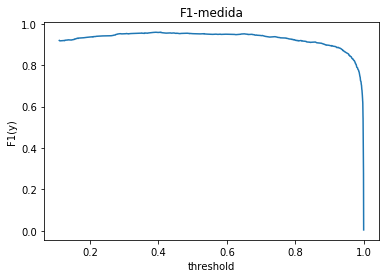

In [35]:
from sklearn.linear_model import LogisticRegression

# Modelo de regressao logistica
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X, y)

# Calcula a probabilidade da predição de cada dado ser de cada classe
prob_X = clf.predict_proba(X)[:,1]

prec, rec, thresholds = precision_recall_curve(y, prob_X)
fpr, tpr, _ = roc_curve(y, prob_X)
roc_auc = auc(fpr, tpr)

F1 = fm(1,prec,rec)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")

plt.figure()
plt.ylabel('F1(y)')
plt.xlabel('threshold')
plt.title('F1-medida')
f = plt.plot(thresholds, F1[:-1])
print("Melhor F1 medida: %.3f e é obtido escolhendo threshold de %.3f" % (max(F1),thresholds[np.argmax(F1)]))

Observando a F1-medida verifica-se que o classificador utilizando regressão logística é bem menos sensível à escolha do threshold do que o classificador linear.

### Parte 3 - Classificação multi-classe


#### (a) Regressão Logística

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, fbeta_score


vehicle_data = pd.read_csv('dataset_vehicle.csv')
X = vehicle_data[vehicle_data.columns.drop('Class')].values
y = vehicle_data['Class'].values

# Usa a função de pre-processamento para centralizar todos os dados, 
# o que trará um ganho de desempenho do algoritmo
X_scaled = scale(X)

# Separação entre os dados de treino e teste, onde a distribuição da frequência dos 
# dados de treino e teste, seguem a distribuição dos dados de origem
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# Utilizando a abordagem 1 contra todos e a regressão logística disponibilizadas pelo pacote scikit-learn
# podemos realizar o treinamento 
clf = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='ovr', max_iter=200)).fit(X_train, y_train)

#Cálculo da probabilidade de cada dado de teste ser da classe correspondente
pred_prob = clf.predict_proba(X_test)

# Como mecanismo de desambiguação, escolhemos a máxima probabilidade encontrada pelos 
# classificadores binários encontrados anteriormente
pred = np.take(clf.label_binarizer_.classes_, pred_prob.argmax(axis=1))

# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, pred)

print("%s\n" % clf.label_binarizer_.classes_)
print("Confusion Matrix\n %s" % cm)

print("F1 medida: %f" % fbeta_score(y_test, pred, average='micro', beta=0.5))

['bus' 'opel' 'saab' 'van']

Confusion Matrix
 [[62  1  1  1]
 [ 3 40 18  3]
 [ 2 14 49  0]
 [ 3  0  1 56]]
F1 medida: 0.814961


/home/intelie/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Observando a matrix de confusão podemos observar que o classificador tem dificuldades para separar as classes Opel e Saab, o que pode indicar que essas classes são parecidas ou então que este classificador não é capaz de identificá-las.

#### (b) K-nearest neighbors

In [44]:
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
import matplotlib.pyplot as plt

K_MAX = 50

vehicle_data = pd.read_csv('dataset_vehicle.csv')
X = vehicle_data[vehicle_data.columns.drop('Class')].values
y = vehicle_data['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    scale(X), y, test_size=0.3, stratify=y, random_state=42)

F1_medida = []

for k in range(1,K_MAX):
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto').fit(X_train,y_train)
    cm_ = confusion_matrix(y_test, clf.predict(X_test))
#     print("k: %d \n %s" % (k,cm_))
    F1_medida.append(fbeta_score(y_test, clf.predict(X_test), average='micro', beta=0.5))

/home/intelie/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


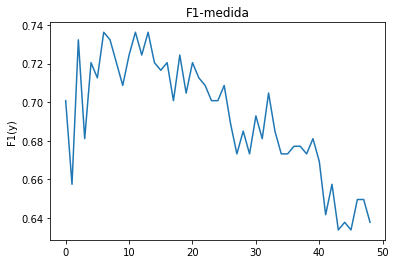

7
0.7362204724409449


In [45]:
plt.figure()
plt.ylabel('F1(y)')
plt.title('F1-medida')
f = plt.plot(F1_medida)
plt.show()

print(np.argmax(F1_medida)+1)
print(np.max(F1_medida))